In [ ]:
# install package references
!pip install keras
!pip install tensorflow

In [47]:
# copy files from s3 to local temp folder
!mkdir /tmp/NN/train
!aws s3 cp s3://f404466-emr-poc/data/tweets/train/tweets.csv /tmp/NN/train/tweets.csv
    
!mkdir /tmp/CNN/test
!aws s3 cp s3://f404466-emr-poc/data/tweets/test/tweets.csv /tmp/NN/test/tweets.csv

mkdir: cannot create directory ‘/tmp/NN/train’: No such file or directory
download: s3://f404466-emr-poc/data/tweets/train/tweets.csv to ../../../../tmp/NN/train/tweets.csv
mkdir: cannot create directory ‘/tmp/CNN/test’: No such file or directory
download: s3://f404466-emr-poc/data/tweets/test/tweets.csv to ../../../../tmp/NN/test/tweets.csv


In [41]:
from numpy.random import seed
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Activation
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import LabelEncoder, OneHotEncoder

seed(10)

#helper functions

def baseline_model():
    # create model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_length))
    model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
    #model.add(Dense(32, input_dim=max_length, kernel_initializer="normal", activation='relu'))
    model.add(Dense(3, kernel_initializer="normal", activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [48]:
df = pd.read_csv("/tmp/NN/train/tweets.csv")
df = df.drop(['Unnamed: 0'], axis=1)

print(df.head())

df=df[df['sentiment']!='MIXED']

x_train = df['tweet']
y_train = df['sentiment']

                                               tweet sentiment
0  imagine turning the key to open your beautiful...   NEUTRAL
1  see what this home has to offer contact me for...   NEUTRAL
2  i would love to show you my at port potomac av...  POSITIVE
3             great inspirational quote folded hands  POSITIVE
4  i entered to win k toward a new home from no p...   NEUTRAL


In [49]:
df = pd.read_csv("/tmp/NN/test/tweets.csv")
df = df.drop(['Unnamed: 0'], axis=1)

print(df.head())

df=df[df['sentiment']!='MIXED']

x_test = df['tweet']
y_test = df['sentiment']

                                               tweet sentiment
0                                          buy under   NEUTRAL
1  reserve plot at the paddock in milton green wi...  POSITIVE
2  today i saw that i was quoted in the sept oct ...   NEUTRAL
3  for real we ll pay the up-front costs to incre...   NEUTRAL
4  searching for your dream home let us help my p...   NEUTRAL


In [50]:
#one hot encoding the 3 different possible sentiments
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_train_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_train_y = np_utils.to_categorical(encoded_train_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_test_Y = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_test_y = np_utils.to_categorical(encoded_test_Y)

x = pd.concat([x_train, x_test])
tokenizer_obj = Tokenizer()   

tokenizer_obj.fit_on_texts(x)    
max_length = max([len(s.split()) for s in x])    
vocab_size = len(tokenizer_obj.word_index)+1  

#Building the vectors of words
x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')

model = baseline_model()

estimator = KerasClassifier(build_fn=baseline_model, epochs=25, batch_size=128, verbose=2)

estimator.fit(x_train_pad, dummy_train_y)

Epoch 1/25
 - 6s - loss: 0.4761 - acc: 0.7848
Epoch 2/25
 - 3s - loss: 0.3827 - acc: 0.8575
Epoch 3/25
 - 3s - loss: 0.3810 - acc: 0.8575
Epoch 4/25
 - 3s - loss: 0.3386 - acc: 0.8619
Epoch 5/25
 - 3s - loss: 0.2219 - acc: 0.9189
Epoch 6/25
 - 3s - loss: 0.1697 - acc: 0.9388
Epoch 7/25
 - 3s - loss: 0.1398 - acc: 0.9515
Epoch 8/25
 - 3s - loss: 0.1213 - acc: 0.9580
Epoch 9/25
 - 3s - loss: 0.1059 - acc: 0.9639
Epoch 10/25
 - 3s - loss: 0.1008 - acc: 0.9651
Epoch 11/25
 - 3s - loss: 0.0924 - acc: 0.9680
Epoch 12/25
 - 3s - loss: 0.0872 - acc: 0.9700
Epoch 13/25
 - 3s - loss: 0.0820 - acc: 0.9703
Epoch 14/25
 - 3s - loss: 0.0779 - acc: 0.9709
Epoch 15/25
 - 3s - loss: 0.0748 - acc: 0.9712
Epoch 16/25
 - 3s - loss: 0.0713 - acc: 0.9726
Epoch 17/25
 - 3s - loss: 0.0680 - acc: 0.9737
Epoch 18/25
 - 3s - loss: 0.0621 - acc: 0.9752
Epoch 19/25
 - 3s - loss: 0.0593 - acc: 0.9758
Epoch 20/25
 - 3s - loss: 0.0547 - acc: 0.9776
Epoch 21/25
 - 3s - loss: 0.0525 - acc: 0.9796
Epoch 22/25
 - 3s - lo

Confusion matrix, without normalization
[[ 280    4   20]
 [   5 6107    2]
 [   9    0 1350]]
Confusion matrix, without normalization
[[  33   47    7]
 [  98 1326   73]
 [  51   74  240]]


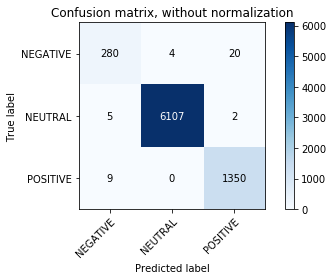

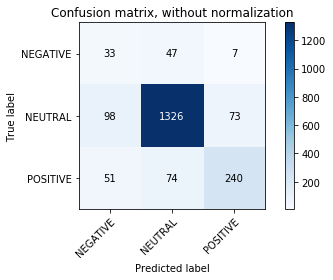

In [51]:
predictions = estimator.predict(x_train_pad)
plot_confusion_matrix(y_train, encoder.inverse_transform(predictions), 
                      classes=np.array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype = '|S10'), 
                      normalize=False)
    
predictions = estimator.predict(x_test_pad)
plot_confusion_matrix(y_test, encoder.inverse_transform(predictions), 
                      classes=np.array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype = '|S10'), 
                      normalize=False)